В этом ноутбуке будем работать с моделями из репозитория [pyod](https://github.com/yzhao062/pyod), которые позиционируют себя как "comprehensive and scalable python toolkit for detecting outlying objects in multivariate data". В библиотеке есть много разных моделей, но из тех что реализованы в нашем проекте, есть только autoencoder и variational autoencoder, поэтому будем сравнивать их по метрикам и времени обучения на [SWAT](https://itrust.sutd.edu.sg/itrust-labs_datasets/dataset_info/) и [SKAB](https://github.com/waico/SKAB) датасетах.

In [ ]:
! pip install pyod 

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from typing import Dict

import warnings
warnings.filterwarnings("ignore")

### Seed fixation

In [3]:
seed_value = 42

import os
os.environ['PYTHONHASHSEED'] = str(seed_value)

import random
random.seed(seed_value)

import numpy as np
np.random.seed(seed_value)

import tensorflow as tf
tf.random.set_seed(seed_value)

# SWAT dataset

### Data processing

In [31]:
df = pd.read_excel("../data/SWAT.xlsx")
df.head()

,Timestamp,FIT101,LIT101,MV101,P101,P102,AIT201,AIT202,AIT203,FIT201,...,P501,P502,PIT501,PIT502,PIT503,FIT601,P601,P602,P603,Normal/Attack
0,28/12/2015 7:50:00 AM,2.462287,541.3740,2,1,1,260.7344,8.409895,324.8398,0.000513,...,2,1,251.4580,1.297536,190.1436,0.000064,1,1,1,Normal
1,28/12/2015 7:50:01 AM,2.441469,541.4918,2,1,1,260.7344,8.412138,324.3015,0.000256,...,2,1,251.4580,1.297536,190.1436,0.000064,1,1,1,Normal
2,28/12/2015 7:50:02 AM,2.428338,541.2955,2,1,1,260.7344,8.414701,323.7888,0.000256,...,2,1,251.4580,1.297536,190.1436,0.000064,1,1,1,Normal
3,28/12/2015 7:50:03 AM,2.425776,542.5124,2,1,1,260.7344,8.420149,323.3530,0.000256,...,2,1,251.4580,1.441707,190.1436,0.000064,1,1,1,Normal
4,28/12/2015 7:50:04 AM,2.424174,542.7871,2,1,1,260.7344,8.423674,322.8916,0.000256,...,2,1,251.2817,1.441707,190.1436,0.000064,1,1,1,Normal


In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18663 entries, 0 to 18662
Data columns (total 53 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0    Timestamp     18663 non-null  object 
 1   FIT101         18663 non-null  float64
 2   LIT101         18663 non-null  float64
 3   MV101          18663 non-null  int64  
 4   P101           18663 non-null  int64  
 5   P102           18663 non-null  int64  
 6    AIT201        18663 non-null  float64
 7   AIT202         18663 non-null  float64
 8   AIT203         18663 non-null  float64
 9   FIT201         18663 non-null  float64
 10   MV201         18663 non-null  int64  
 11   P201          18663 non-null  int64  
 12   P202          18663 non-null  int64  
 13  P203           18663 non-null  int64  
 14   P204          18663 non-null  int64  
 15  P205           18663 non-null  int64  
 16  P206           18663 non-null  int64  
 17  DPIT301        18663 non-null  float64
 18  FIT301

Вектор Normal/Attack указывает на то, являются ли наблюдения аномальными

In [34]:
df['Normal/Attack'].replace({'Normal':0, 'Attack':1}, inplace=True)
df["anomaly"] = df["Normal/Attack"]

anomaly = df.anomaly
df.drop(["Normal/Attack"], axis=1, inplace=True)

In [35]:
important_features = [
    'LIT101', 'MV301', 'MV302', ' MV303', 'MV304', 'P302', 'AIT401', 'AIT504', 'FIT504', 'PIT502', 'P602']

In [36]:
df = df[important_features]
df.head()

,LIT101,MV301,MV302,MV303,MV304,P302,AIT401,AIT504,FIT504,PIT502,P602
0,541.3740,1,1,1,1,1,148.808,12.03538,0.306761,1.297536,1
1,541.4918,1,1,1,1,1,148.808,12.03538,0.306761,1.297536,1
2,541.2955,1,1,1,1,1,148.808,12.03538,0.306761,1.297536,1
3,542.5124,1,1,1,1,1,148.808,12.03538,0.306761,1.441707,1
4,542.7871,1,1,1,1,1,148.808,12.03538,0.306761,1.441707,1


In [37]:
first_anomaly_index = anomaly[anomaly == 1].index[0]
train_size = int(first_anomaly_index * 0.8)

### Autoencoder prediction

In [6]:
from pyod.models.auto_encoder import AutoEncoder
from tensorflow.keras.losses import mean_absolute_error as mae

In [7]:
ae_params = {
    "hidden_neurons": [64, 32, 16, 8, 8, 16, 32, 64],
    "epochs": 10,
    "batch_size": 16,
    "loss": mae,
    "random_state": 42,
}

In [41]:
%%time
ae = AutoEncoder(**ae_params).fit(df[:train_size])

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_57 (Dense)            (None, 11)                132       
                                                                 
 dropout_48 (Dropout)        (None, 11)                0         
                                                                 
 dense_58 (Dense)            (None, 11)                132       
                                                                 
 dropout_49 (Dropout)        (None, 11)                0         
                                                                 
 dense_59 (Dense)            (None, 64)                768       
                                                                 
 dropout_50 (Dropout)        (None, 64)                0         
                                                                 
 dense_60 (Dense)            (None, 32)               

In [42]:
r = pd.Series(ae.decision_function(df[train_size:]))
prediction = (r > r.quantile(0.75) + 1.5 * (r.quantile(0.75) - r.quantile(0.25))).values

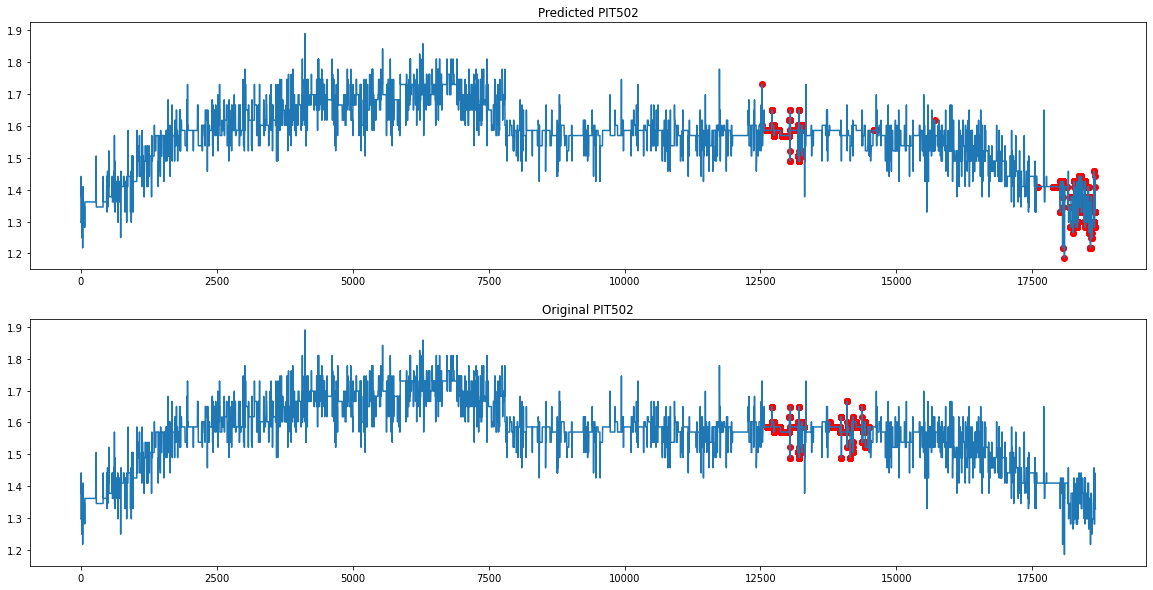

In [43]:
p = "PIT502"

fig, axs = plt.subplots(2, 1, figsize=(20,10))
p_data = df[p]
axs[0].plot(p_data)
axs[1].plot(p_data)

y = pd.Series(prediction, index=df[train_size:].index)
anomalies_indecies = y.index[y == 1]
axs[0].scatter(anomalies_indecies, p_data[anomalies_indecies], color='r')
axs[0].set_title(f"Predicted {p}")

y = pd.Series(anomaly)
anomalies_indecies = pd.Series(y.values).index[y == 1]
axs[1].scatter(df.index[anomalies_indecies], p_data[anomalies_indecies], color='r')
axs[1].set_title(f"Original {p}")

plt.show()

In [35]:
def f1_score(test, pred):
    p=pred.values.astype(bool)
    t=test.values.astype(bool)
    tp = (p & t).sum()
    fp = (p & ~t).sum()
    fn = (~p & t).sum()
    return tp / (tp + 0.5 * (fp + fn))

In [51]:
print(f"F1 = {round(f1_score(pd.Series(prediction), anomaly[train_size:]), 2)}")

F1 = 0.44


### Variational autoencoder prediction

In [78]:
from pyod.models.vae import VAE

In [8]:
vae_params = {
    "encoder_neurons": [64, 32, 16, 8],
    "decoder_neurons": [16, 32, 64, 8],
    "latent_dim": 8,
    "epochs": 10,
    "batch_size": 16,
    "loss": mae,
    "random_state": 42,
}

In [53]:
%%time
vae = VAE(**vae_params).fit(df[:train_size])

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 11)]         0           []                               
                                                                                                  
 dense_68 (Dense)               (None, 11)           132         ['input_3[0][0]']                
                                                                                                  
 dense_69 (Dense)               (None, 64)           768         ['dense_68[0][0]']               
                                                                                                  
 dropout_58 (Dropout)           (None, 64)           0           ['dense_69[0][0]']               
                                                                                            

568/568 [==============================] - 7s 5ms/step - loss: 6.4660 - val_loss: 5.7605
Epoch 2/10
568/568 [==============================] - 2s 4ms/step - loss: 5.5609 - val_loss: 5.6947
Epoch 3/10
568/568 [==============================] - 4s 6ms/step - loss: 5.4928 - val_loss: 5.6906
Epoch 4/10
568/568 [==============================] - 2s 4ms/step - loss: 5.4714 - val_loss: 5.6040
Epoch 5/10
568/568 [==============================] - 2s 4ms/step - loss: 5.4244 - val_loss: 5.5992
Epoch 6/10
568/568 [==============================] - 2s 4ms/step - loss: 5.4063 - val_loss: 5.6056
Epoch 7/10
568/568 [==============================] - 2s 4ms/step - loss: 5.3951 - val_loss: 5.5971
Epoch 8/10
568/568 [==============================] - 2s 4ms/step - loss: 5.3807 - val_loss: 5.5944
Epoch 9/10
568/568 [==============================] - 2s 4ms/step - loss: 5.3791 - val_loss: 5.5945
Epoch 10/10
568/568 [==============================] - 2s 4ms/step - loss: 5.3767 - val_loss: 5.5944
CPU times:

In [54]:
r = pd.Series(vae.decision_function(df[train_size:]))
prediction = (r > r.quantile(0.75) + 1.5 * (r.quantile(0.75) - r.quantile(0.25))).values

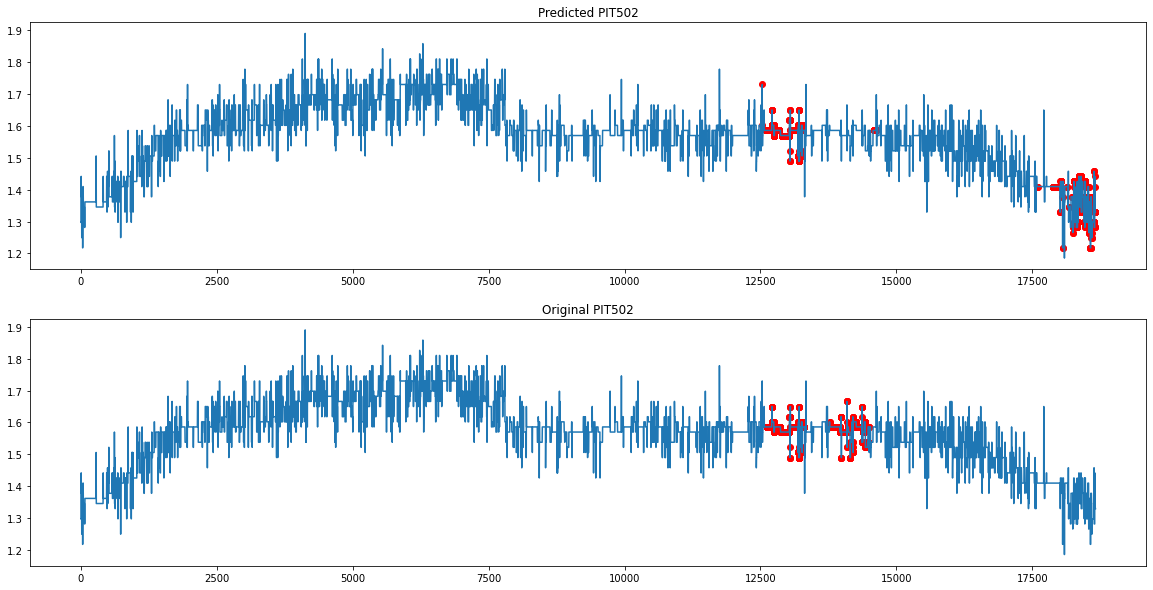

In [55]:
p = "PIT502"

fig, axs = plt.subplots(2, 1, figsize=(20,10))
p_data = df[p]
axs[0].plot(p_data)
axs[1].plot(p_data)

y = pd.Series(prediction, index=df[train_size:].index)
anomalies_indecies = y.index[y == 1]
axs[0].scatter(anomalies_indecies, p_data[anomalies_indecies], color='r')
axs[0].set_title(f"Predicted {p}")

y = pd.Series(anomaly)
anomalies_indecies = pd.Series(y.values).index[y == 1]
axs[1].scatter(df.index[anomalies_indecies], p_data[anomalies_indecies], color='r')
axs[1].set_title(f"Original {p}")

plt.show()

In [56]:
print(f"F1 = {round(f1_score(pd.Series(prediction), anomaly[train_size:]), 2)}")

F1 = 0.46


# SKAB dataset

### Load & process data

In [86]:
df_train = pd.read_csv("../data/valve1/6.csv", sep=";", index_col="datetime", parse_dates=True)
df_train.head()

,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS,anomaly,changepoint
datetime,,,,,,,,,,
2020-03-09 12:14:36,0.027429,0.040353,0.770310,0.382638,71.2129,25.0827,219.789,32.0000,0.0,0.0
2020-03-09 12:14:37,0.027269,0.040226,1.096960,0.710565,71.4284,25.0863,233.117,32.0104,0.0,0.0
2020-03-09 12:14:38,0.027040,0.039773,1.140150,0.054711,71.3468,25.0874,234.745,32.0000,0.0,0.0
2020-03-09 12:14:39,0.027563,0.040313,1.108680,-0.273216,71.3258,25.0897,205.254,32.0104,0.0,0.0
2020-03-09 12:14:41,0.026570,0.039566,0.704404,0.382638,71.2725,25.0831,212.095,33.0000,0.0,0.0


In [87]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1154 entries, 2020-03-09 12:14:36 to 2020-03-09 12:34:35
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Accelerometer1RMS    1154 non-null   float64
 1   Accelerometer2RMS    1154 non-null   float64
 2   Current              1154 non-null   float64
 3   Pressure             1154 non-null   float64
 4   Temperature          1154 non-null   float64
 5   Thermocouple         1154 non-null   float64
 6   Voltage              1154 non-null   float64
 7   Volume Flow RateRMS  1154 non-null   float64
 8   anomaly              1154 non-null   float64
 9   changepoint          1154 non-null   float64
dtypes: float64(10)
memory usage: 99.2 KB


In [88]:
first_anomaly_index = df_train.index.get_loc(df_train[df_train.anomaly == 1].index[0])
train_size = int(first_anomaly_index * 0.8)

In [100]:
important_features = ['Volume Flow RateRMS', 'Temperature', 'Pressure', ]
anomaly = df_train.anomaly

df_train = df_train[important_features]
df_train.head()

,Volume Flow RateRMS,Temperature,Pressure
datetime,,,
2020-03-09 12:14:36,32.0000,71.2129,0.382638
2020-03-09 12:14:37,32.0104,71.4284,0.710565
2020-03-09 12:14:38,32.0000,71.3468,0.054711
2020-03-09 12:14:39,32.0104,71.3258,-0.273216
2020-03-09 12:14:41,33.0000,71.2725,0.382638


### Autoencoder prediction

In [101]:
print("\n".join(map(lambda x: f"{x} {ae_params[x]}", ae_params)))

hidden_neurons [64, 32, 8, 2, 2, 8, 32, 64]
epochs 10
batch_size 4
loss <function mean_absolute_error at 0x7f8165b5c9d0>
random_state 42


In [102]:
ae_params["hidden_neurons"] = [64, 32, 8, 2, 2, 8, 32, 64]
ae_params["batch_size"] = 4

class AutoencoderPredictor:
    def fit(self, df_train, **params):
        self.model = AutoEncoder(**params).fit(df_train)
        
    def predict(self, dfs_test: Dict[str, pd.DataFrame]) -> Dict[str, pd.Series]:
        predictions = {}
        for file_name, df in dfs_test.items():
            y_test = df.anomaly
            df = df[important_features]
            r = pd.Series(self.model.decision_function(df), index=df.index)
            
            smoothed = r.rolling(window = 10).mean().fillna(r.iloc[0])
            diff = smoothed.diff(10).abs()

            IQR = diff.quantile(0.75) - diff.quantile(0.75)
            UCL = diff.quantile(0.75) + 1.5 * IQR

            s = diff > UCL
            is_anomaly = s.rolling(window = 10).mean().fillna(s.iloc[0])

            anomalous_data_indices = pd.Series(is_anomaly.index[is_anomaly > 0])
            prediction = pd.Series(data=0, index=df.index)
            prediction[anomalous_data_indices] = 1
            predictions[file_name] = prediction
            
        return predictions

In [103]:
%%time
ae = AutoencoderPredictor()
ae.fit(df_train[:train_size], **ae_params)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_128 (Dense)           (None, 3)                 12        
                                                                 
 dropout_114 (Dropout)       (None, 3)                 0         
                                                                 
 dense_129 (Dense)           (None, 3)                 12        
                                                                 
 dropout_115 (Dropout)       (None, 3)                 0         
                                                                 
 dense_130 (Dense)           (None, 64)                256       
                                                                 
 dropout_116 (Dropout)       (None, 64)                0         
                                                                 
 dense_131 (Dense)           (None, 32)               

In [104]:
from loader import load_df_by_names

df_by_names = load_df_by_names("../data/", ["valve1", "valve2"])
y_test_by_names = {name: df.anomaly for name, df in df_by_names.items()}
predictions_by_names = ae.predict(df_by_names)

In [105]:
prediction = predictions_by_names['../data/valve1/3.csv']

In [106]:
df = df_by_names['../data/valve1/3.csv']

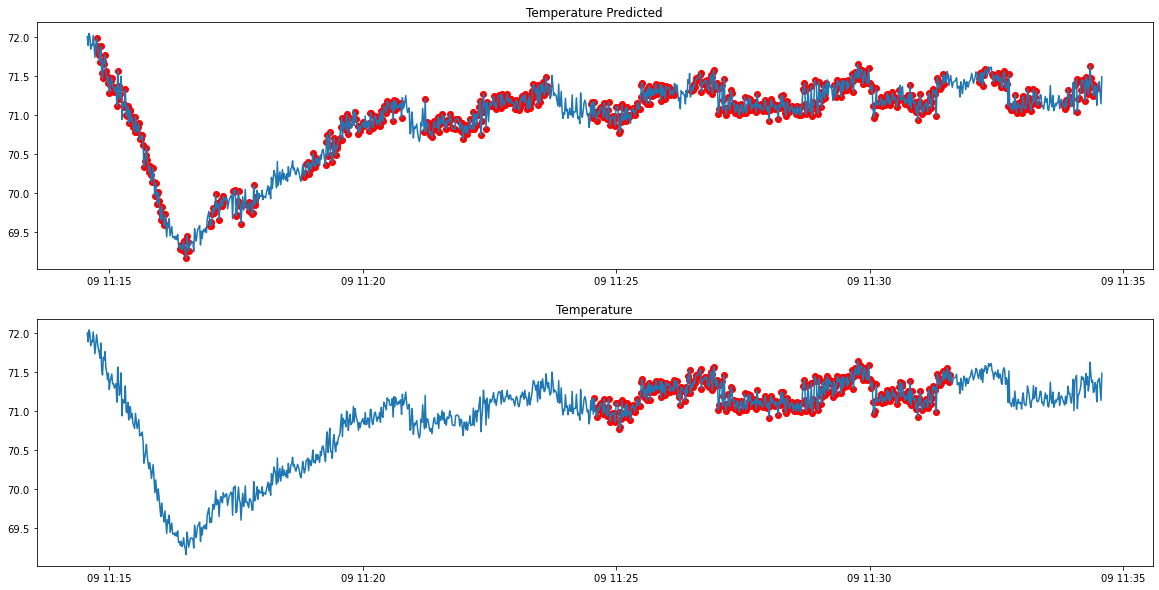

In [107]:
fig, axs = plt.subplots(2, 1, figsize=(20,10))
temperatures = df.Temperature
axs[0].plot(temperatures)
axs[1].plot(temperatures)

y = pd.Series(prediction)
anomalies_indecies = y.index[y == 1]
axs[0].scatter(anomalies_indecies, temperatures[anomalies_indecies], color='r')
axs[0].set_title("Temperature Predicted")

y = pd.Series(df.anomaly)
anomalies_indecies = pd.Series(y.values).index[y == 1]
axs[1].scatter(df.index[anomalies_indecies], temperatures[anomalies_indecies], color='r')
axs[1].set_title("Temperature")

plt.show()

In [108]:
print(f"F1 = {round(f1_score(pd.Series(prediction), df.anomaly), 2)}")

F1 = 0.59


### Variational autoencoder prediction

In [75]:
print("\n".join(map(lambda x: f"{x} {vae_params[x]}", vae_params)))

encoder_neurons [64, 32, 16, 8, 4, 2]
decoder_neurons [2, 4, 8, 16, 32, 64]
latent_dim 2
epochs 10
batch_size 4
loss <function mean_absolute_error at 0x7f8165b5c9d0>
random_state 42


In [76]:
vae_params["encoder_neurons"] = [64, 32, 16, 8, 4, 2]
vae_params["decoder_neurons"] = [2, 4, 8, 16, 32, 64]
vae_params["latent_dim"] = 2
vae_params["batch_size"] = 4

class VAEPredictor:
    def fit(self, df_train, **params):
        self.model = VAE(**params).fit(df_train)
        
    def predict(self, dfs_test: Dict[str, pd.DataFrame]) -> Dict[str, pd.Series]:
        predictions = {}
        for file_name, df in dfs_test.items():
            y_test = df.anomaly
            df = df[important_features]
            r = pd.Series(self.model.decision_function(df), index=df.index)
            
            smoothed = r.rolling(window = 10).mean().fillna(r.iloc[0])
            diff = smoothed.diff(10).abs()

            IQR = diff.quantile(0.75) - diff.quantile(0.75)
            UCL = diff.quantile(0.75) + 1.5 * IQR

            s = diff > UCL
            is_anomaly = s.rolling(window = 10).mean().fillna(s.iloc[0])

            anomalous_data_indices = pd.Series(is_anomaly.index[is_anomaly > 0])
            prediction = pd.Series(data=0, index=df.index)
            prediction[anomalous_data_indices] = 1
            predictions[file_name] = prediction
            
        return predictions

In [79]:
%%time
vae = VAEPredictor()
vae.fit(df_train[:train_size], **vae_params)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 3)]          0           []                               
                                                                                                  
 dense_89 (Dense)               (None, 3)            12          ['input_1[0][0]']                
                                                                                                  
 dense_90 (Dense)               (None, 64)           256         ['dense_89[0][0]']               
                                                                                                  
 dropout_82 (Dropout)           (None, 64)           0           ['dense_90[0][0]']               
                                                                                              

Epoch 1/10
104/104 [==============================] - 5s 8ms/step - loss: 3.0323 - val_loss: 2.7521
Epoch 2/10
104/104 [==============================] - 0s 4ms/step - loss: 2.5978 - val_loss: 2.5407
Epoch 3/10
104/104 [==============================] - 0s 4ms/step - loss: 2.5414 - val_loss: 2.5264
Epoch 4/10
104/104 [==============================] - 0s 4ms/step - loss: 2.5217 - val_loss: 2.5201
Epoch 5/10
104/104 [==============================] - 0s 5ms/step - loss: 2.5210 - val_loss: 2.5117
Epoch 6/10
104/104 [==============================] - 0s 4ms/step - loss: 2.5185 - val_loss: 2.5136
Epoch 7/10
104/104 [==============================] - 0s 4ms/step - loss: 2.5132 - val_loss: 2.5120
Epoch 8/10
104/104 [==============================] - 0s 4ms/step - loss: 2.5104 - val_loss: 2.5109
Epoch 9/10
104/104 [==============================] - 1s 7ms/step - loss: 2.5131 - val_loss: 2.5113
Epoch 10/10
104/104 [==============================] - 0s 4ms/step - loss: 2.5156 - val_loss: 2.5108

In [80]:
df_by_names = load_df_by_names("../data/", ["valve1", "valve2"])
y_test_by_names = {name: df.anomaly for name, df in df_by_names.items()}
predictions_by_names = vae.predict(df_by_names)

In [81]:
prediction = predictions_by_names['../data/valve1/3.csv']

In [82]:
df = df_by_names['../data/valve1/3.csv']

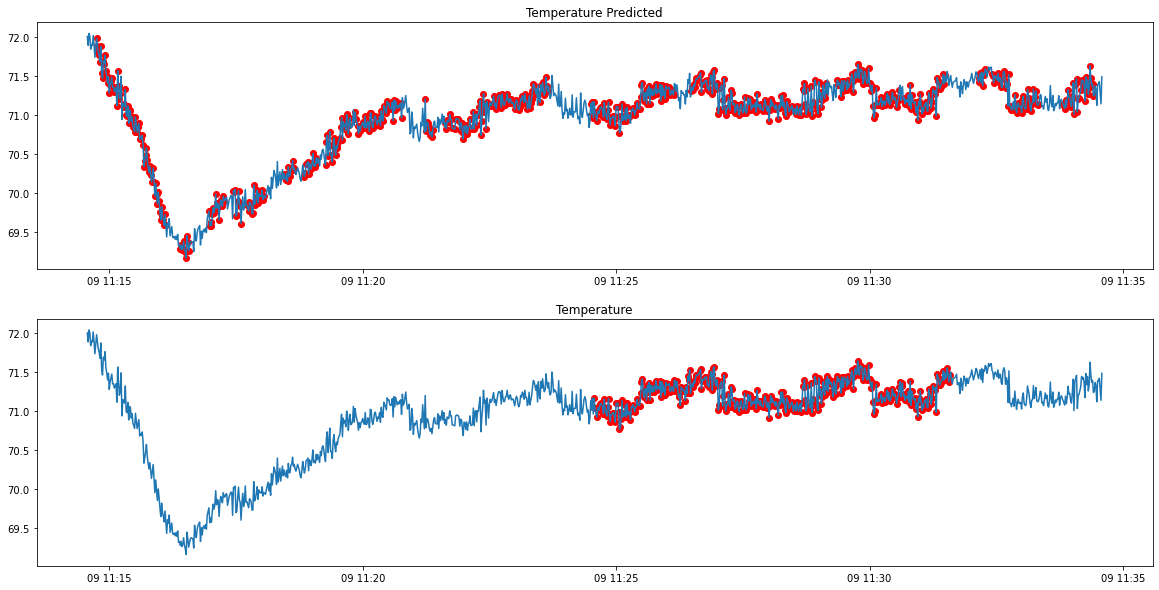

In [84]:
fig, axs = plt.subplots(2, 1, figsize=(20,10))
temperatures = df.Temperature
axs[0].plot(temperatures)
axs[1].plot(temperatures)

y = pd.Series(prediction)
anomalies_indecies = y.index[y == 1]
axs[0].scatter(anomalies_indecies, temperatures[anomalies_indecies], color='r')
axs[0].set_title("Temperature Predicted")

y = pd.Series(df.anomaly)
anomalies_indecies = pd.Series(y.values).index[y == 1]
axs[1].scatter(df.index[anomalies_indecies], temperatures[anomalies_indecies], color='r')
axs[1].set_title("Temperature")

plt.show()

In [85]:
print(f"F1 = {round(f1_score(pd.Series(prediction), df.anomaly), 2)}")

F1 = 0.58
